In [10]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [11]:
#  XGBoost
try:
    from xgboost import XGBRegressor
    xgb_available = True
except Exception:
    xgb_available = False

# ---------------- CONFIG ----------------
INPUT_FILE = "Goals & Assist .xlsx"   # update path if needed
RANDOM_STATE = 42
TEST_SIZE = 0.20
N_ITER = 30
CV = 3

# Output files
RF_GOALS_FILE = "rf_model_goals.pkl"
XGB_GOALS_FILE = "xgb_model_goals.pkl"
RF_ASSISTS_FILE = "rf_model_assists.pkl"
XGB_ASSISTS_FILE = "xgb_model_assists.pkl"
CLEANED_CSV = "cleaned_all_features.csv"
# ----------------------------------------

In [12]:

def clean_column_names(df):
    df.columns = (df.columns
                  .str.replace(r"[^A-Za-z0-9_]", "", regex=True)
                  .str.replace(" ", "_"))
    return df

def load_data(path):
    df = pd.read_excel(path)
    df = clean_column_names(df)
    return df

def basic_eda(df):
    print("\n=== BASIC EDA ===")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("\nHead:\n", df.head(5))
    print("\nInfo:")
    print(df.info())
    print("\nNumeric summary:\n", df.describe().T)
    print("\nMissing values per column:\n", df.isnull().sum())


In [13]:
def plots_numeric(df):
    numeric = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric:
        return
    # Histograms
    df[numeric].hist(figsize=(14,10), bins=30)
    plt.suptitle("Histograms (numeric)")
    plt.tight_layout()
    plt.show()

    # Boxplots (dynamic)
    cols = 4
    rows = (len(numeric) // cols) + (1 if len(numeric) % cols else 0)
    plt.figure(figsize=(16, rows * 3.5))
    for i, c in enumerate(numeric, 1):
        plt.subplot(rows, cols, i)
        sns.boxplot(x=df[c])
        plt.title(c)
    plt.tight_layout()
    plt.show()

def correlation_heatmap(df):
    numeric = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(12,10))
    sns.heatmap(numeric.corr(), cmap="coolwarm", center=0)
    plt.title("Correlation heatmap (numeric)")
    plt.show()

In [14]:
def handle_missing(df):
    # numeric -> median, categorical -> mode
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
    if numeric_cols:
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    for c in cat_cols:
        df[c] = df[c].fillna(df[c].mode().iloc[0])
    return df

def remove_outliers_iqr(df):
    df_out = df.copy()
    numeric_cols = df_out.select_dtypes(include=[np.number]).columns.tolist()
    mask = pd.Series(True, index=df_out.index)
    for c in numeric_cols:
        q1 = df_out[c].quantile(0.25)
        q3 = df_out[c].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        mask = mask & df_out[c].between(lower, upper)
    df_clean = df_out[mask].copy()
    return df_clean

In [15]:
def build_preprocessor(categorical_cols):
    # Use sparse_output=False for sklearn >=1.2 compatibility
    ohe = OneHotEncoder(drop="first", sparse_output=False)
    preproc = ColumnTransformer(
        transformers=[("ohe", ohe, categorical_cols)],
        remainder="passthrough",
        verbose_feature_names_out=False
    )
    return preproc

def get_feature_names(preprocessor, X_sample, categorical_cols):
    """
    Return full feature names (OHE feature names in order + numeric passthrough names).
    preprocessor must be fitted.
    X_sample = DataFrame of X used for fitting.
    """
    ohe = preprocessor.named_transformers_["ohe"]
    # get OHE names
    cat_names = list(ohe.get_feature_names_out(categorical_cols)) if hasattr(ohe, "get_feature_names_out") else []
    # numeric passthrough names: columns in X_sample excluding categorical_cols
    numeric_names = [c for c in X_sample.columns.tolist() if c not in categorical_cols]
    return cat_names + numeric_names

In [16]:
def train_and_tune(X_train, y_train, model_type="rf"):
    """
    model_type: "rf" or "xgb"
    Returns: fitted RandomizedSearchCV object (best_estimator_ is a pipeline with steps 'preprocessor' and 'model')
    """
    if model_type == "rf":
        base_model = RandomForestRegressor(random_state=RANDOM_STATE)
        param_dist = {
            "model__n_estimators": randint(200, 1000),
            "model__max_depth": randint(3, 20),
            "model__min_samples_split": randint(2, 20),
            "model__min_samples_leaf": randint(1, 10),
            "model__max_features": ["sqrt", "log2", None]
        }
    elif model_type == "xgb":
        if not xgb_available:
            raise RuntimeError("xgboost not installed in environment")
        base_model = XGBRegressor(objective="reg:squarederror", random_state=RANDOM_STATE, verbosity=0, n_jobs=-1)
        param_dist = {
            "model__n_estimators": randint(200, 900),
            "model__learning_rate": uniform(0.01, 0.3),
            "model__max_depth": randint(3, 12),
            "model__subsample": uniform(0.5, 0.5),
            "model__colsample_bytree": uniform(0.5, 0.5)
        }
    else:
        raise ValueError("model_type must be 'rf' or 'xgb'")

    pipe = Pipeline([("preprocessor", preprocessor), ("model", base_model)])
    search = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=N_ITER, cv=CV, scoring="r2", n_jobs=-1, random_state=RANDOM_STATE)
    search.fit(X_train, y_train)
    return search

In [17]:
def evaluate(search_obj, X_test, y_test, label):
    best_pipe = search_obj.best_estimator_
    preds = best_pipe.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)
    print(f"\n{label} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return best_pipe, preds, {"MAE": mae, "RMSE": rmse, "R2": r2}

def extract_feature_importances_from_pipeline(best_pipe, X_full, categorical_cols):
    """
    Given best pipeline (with 'preprocessor' and 'model'), return dataframe of feature importances.
    """
    try:
        pre = best_pipe.named_steps["preprocessor"]
        model = best_pipe.named_steps["model"]
    except Exception as e:
        print("Pipeline structure unexpected:", e)
        return None

    # Fit preprocessor on full X to be safe (no data leakage since this is for names only)
    pre.fit(X_full)
    feat_names = get_feature_names(pre, X_full, categorical_cols)

    if not hasattr(model, "feature_importances_"):
        print("Model has no feature_importances_.")
        return None

    imps = model.feature_importances_
    if len(feat_names) != len(imps):
        print("Feature name count and importance length mismatch:", len(feat_names), "vs", len(imps))
        # fallback: try to return numeric-only importances aligned to X_full.columns order
        return None

    fi_df = pd.DataFrame({"feature": feat_names, "importance": imps}).sort_values("importance", ascending=False)
    return fi_df




=== BASIC EDA ===
Shape: (2274, 14)
Columns: ['Position', 'Age', 'MatchesPlayed', 'Starts', 'Minutes', '90sPlayed', 'Goals', 'Assists', 'GoalsPer90', 'AssistsPer90', 'NonPenaltyGoalsPer90', 'xGPer90', 'xAGPer90', 'npxGPer90']

Head:
   Position  Age  MatchesPlayed  Starts  Minutes  90sPlayed  Goals  Assists  \
0       AT   32             38      38     3371       37.5     29       18   
1       DF   33             37      37     3330       37.0      3        1   
2       MT   22             37      37     3160       35.1      0        4   
3       MT   25             35      30     2599       28.9      5        5   
4       DF   25             31      30     2560       28.4      1        2   

   GoalsPer90  AssistsPer90  NonPenaltyGoalsPer90  xGPer90  xAGPer90  \
0        0.77          0.48                  0.53     0.67      0.38   
1        0.08          0.03                  0.08     0.06      0.02   
2        0.00          0.11                  0.00     0.03      0.09   
3       

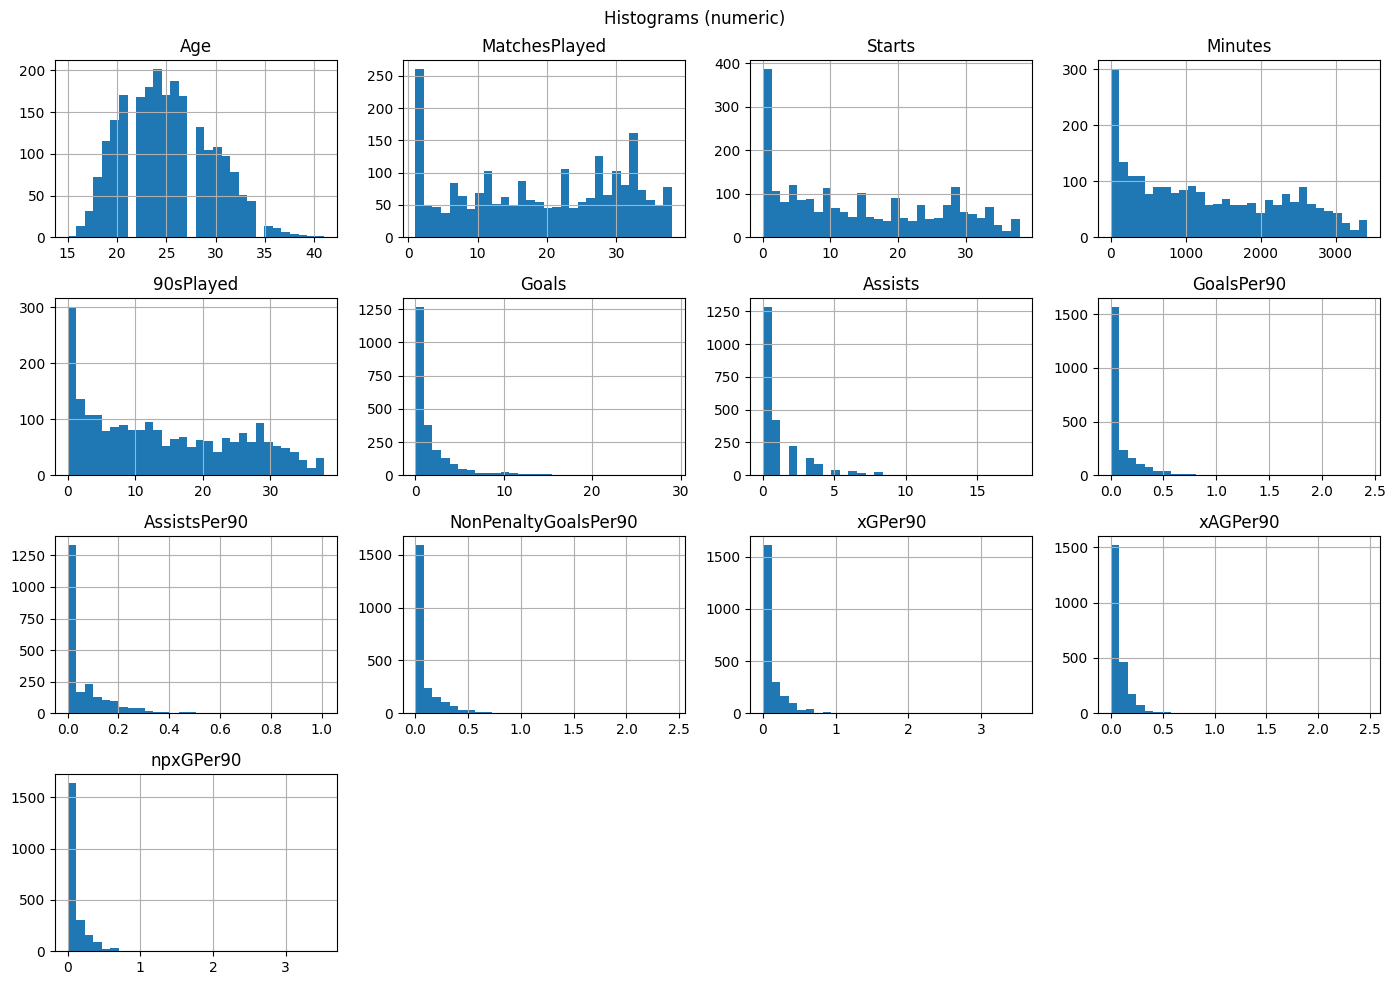

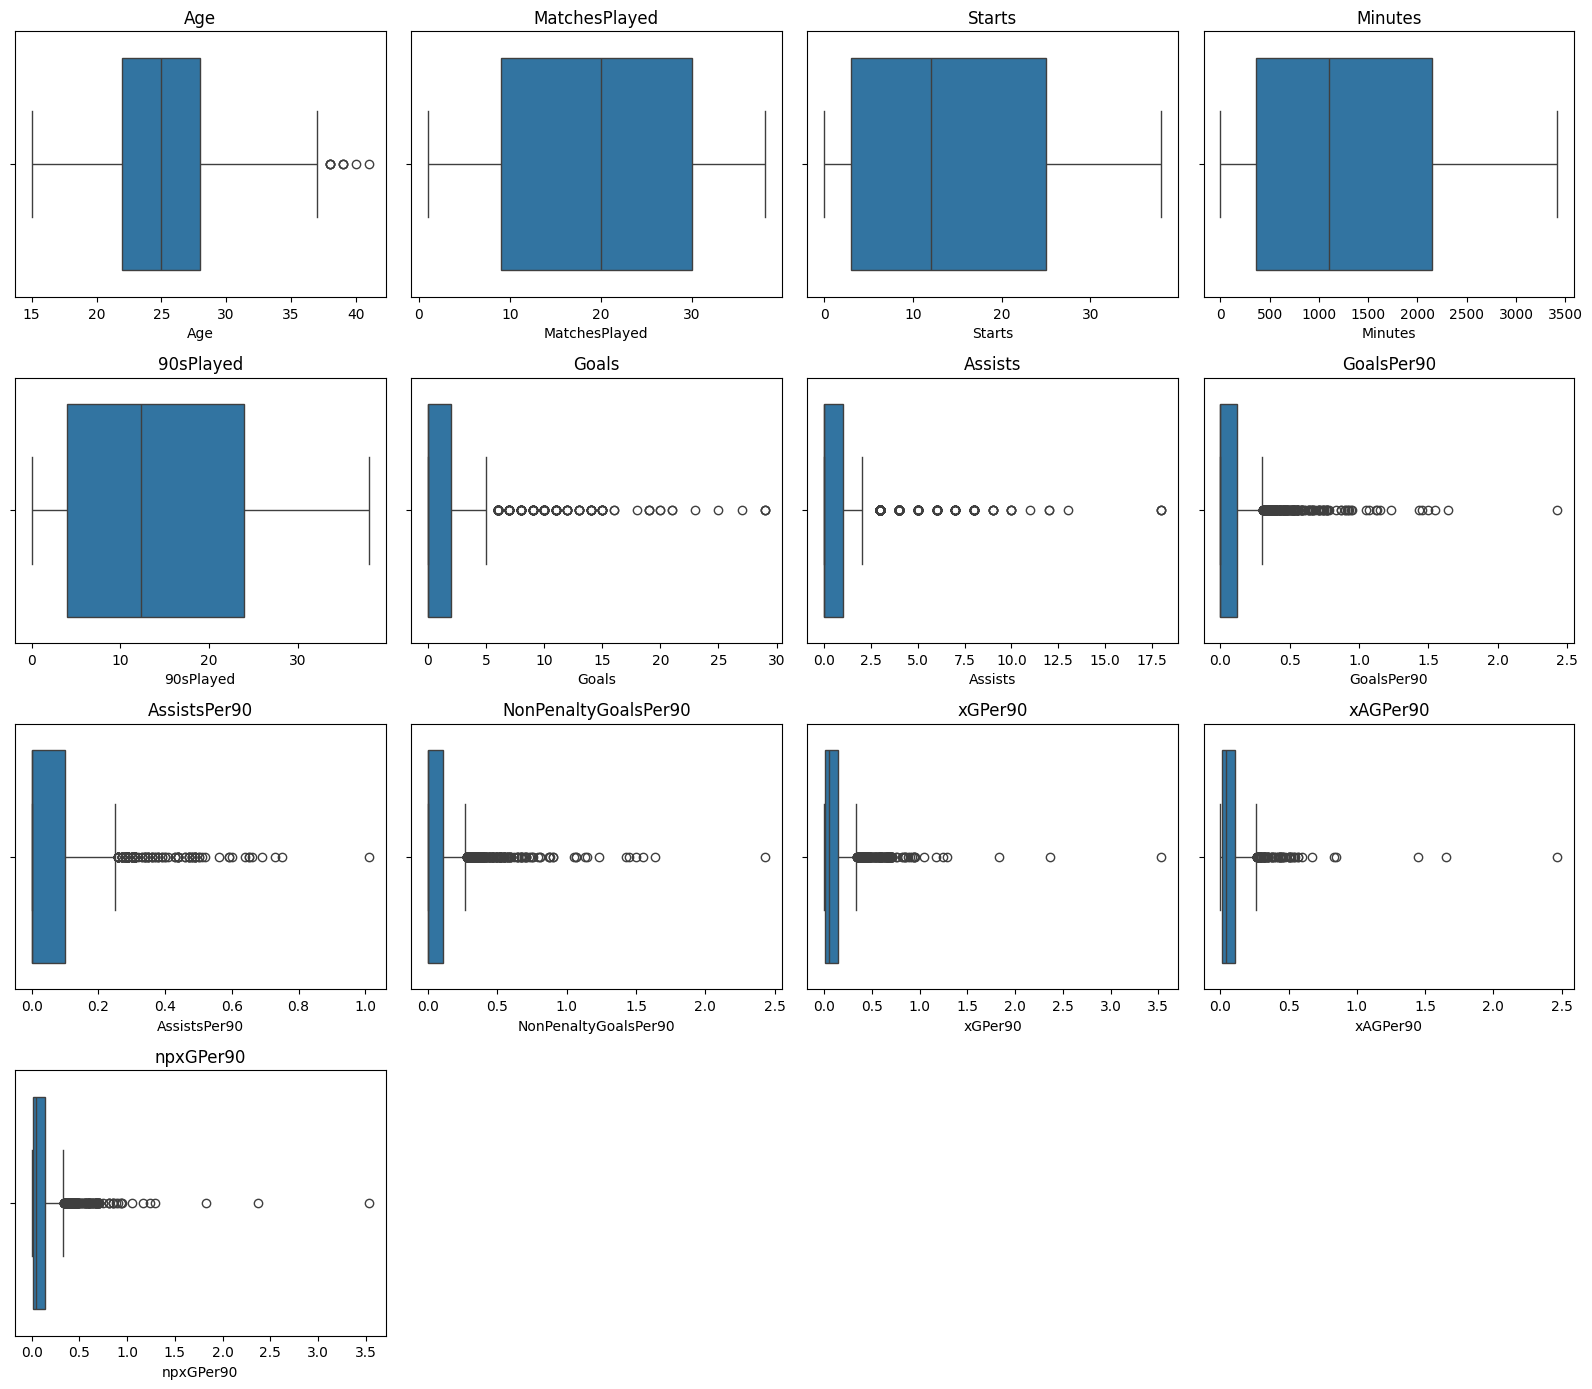

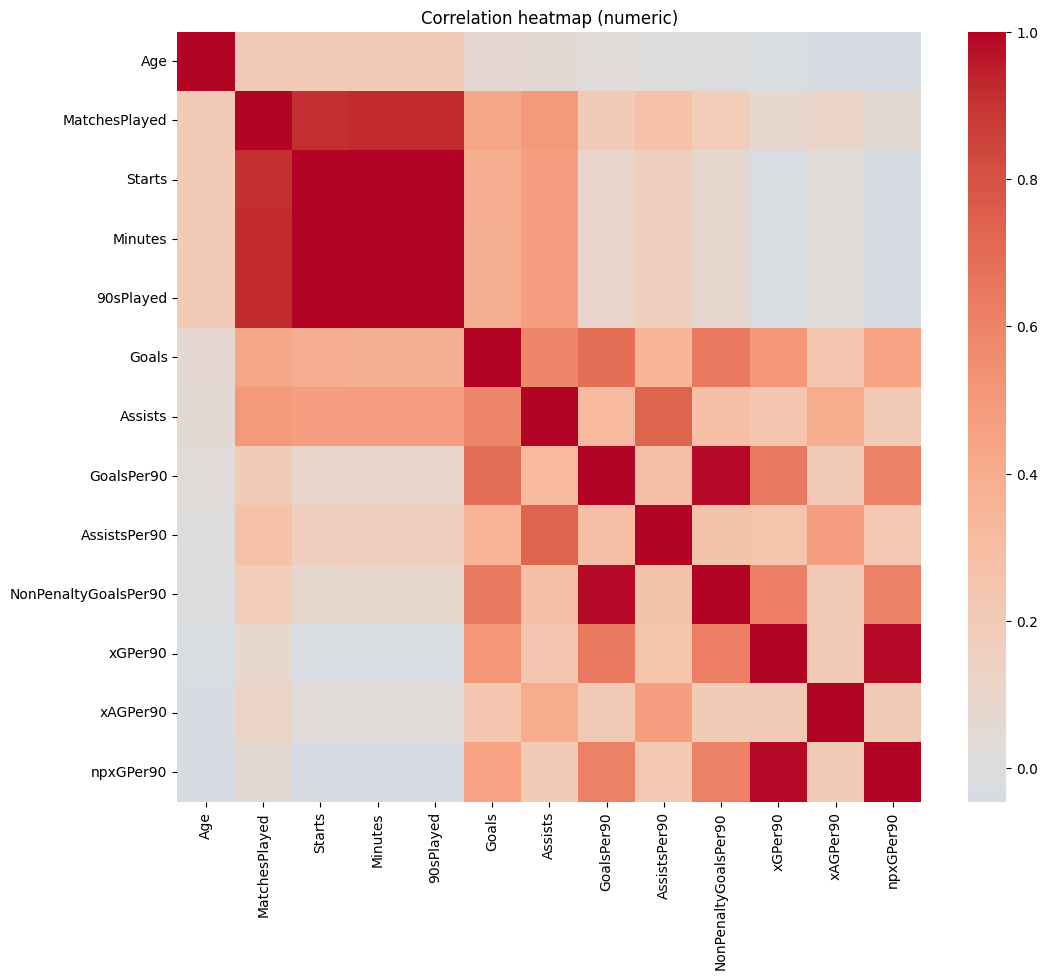


Outlier removal done. Rows removed: 631 (27.75%). New shape: (1643, 14)
Cleaned CSV saved: cleaned_all_features.csv

Categorical (OHE): ['Position']
Numeric features used: ['Age', 'MatchesPlayed', 'Starts', 'Minutes', '90sPlayed', 'GoalsPer90', 'AssistsPer90', 'NonPenaltyGoalsPer90', 'xGPer90', 'xAGPer90', 'npxGPer90']


===== TRAINING FOR TARGET: Goals =====

-- RandomForest tuning & training --

Goals - RandomForest -> MAE: 0.0278, RMSE: 0.1070, R2: 0.9891
Saved RF pipeline: rf_model_goals.pkl

Top RF importances for Goals:
                  feature  importance
11            GoalsPer90    0.781682
8                Minutes    0.064720
9              90sPlayed    0.060820
7                 Starts    0.042310
13  NonPenaltyGoalsPer90    0.041284
6          MatchesPlayed    0.005188
15              xAGPer90    0.001790
5                    Age    0.000750
14               xGPer90    0.000431
16             npxGPer90    0.000294

-- XGBoost tuning & training --

Goals - XGBoost -> MAE: 0

In [18]:
# ----------------- MAIN -----------------
if __name__ == "__main__":
    # 1. Load
    df = load_data(INPUT_FILE)
    basic_eda(df)

    # 2. Quick plots
    plots_numeric(df)
    correlation_heatmap(df)

    # 3. Missing handling
    df = handle_missing(df)

    # 4. Outlier removal (IQR across numeric columns)
    before = df.shape[0]
    df = remove_outliers_iqr(df)
    removed = before - df.shape[0]
    print(f"\nOutlier removal done. Rows removed: {removed} ({removed/before*100:.2f}%). New shape: {df.shape}")

    # Save cleaned snapshot
    df.to_csv(CLEANED_CSV, index=False)
    print(f"Cleaned CSV saved: {CLEANED_CSV}")

    # 5. Setup features & categorical list
    # Targets are Goals and Assists
    targets = []
    for t in ["Goals", "Assists"]:
        if t in df.columns:
            targets.append(t)
        else:
            raise KeyError(f"Target column '{t}' not found in dataset")

    # use all columns except target for each target (you requested Option A)
    categorical_cols = ["Position"] if "Position" in df.columns else []
    numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c not in targets]

    print("\nCategorical (OHE):", categorical_cols)
    print("Numeric features used:", numeric_cols)

    # 6. Build preprocessor (global variable used in train function)
    preprocessor = build_preprocessor(categorical_cols)

    results_summary = {}

    # 7. For each target train RF and XGB
    for target in targets:
        print(f"\n\n===== TRAINING FOR TARGET: {target} =====")
        X = df.drop(columns=[target])
        y = df[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

        # RandomForest
        print("\n-- RandomForest tuning & training --")
        rf_search = train_and_tune(X_train, y_train, model_type="rf")
        rf_pipe, rf_preds, rf_metrics = evaluate(rf_search, X_test, y_test, f"{target} - RandomForest")
        # Save RF pipeline (includes preprocessor)
        rf_filename = RF_GOALS_FILE if target == "Goals" else RF_ASSISTS_FILE
        joblib.dump(rf_pipe, rf_filename)
        print(f"Saved RF pipeline: {rf_filename}")

        # Feature importances RF
        fi_rf = extract_feature_importances_from_pipeline(rf_pipe, X, categorical_cols)
        if fi_rf is not None:
            print(f"\nTop RF importances for {target}:\n", fi_rf.head(10))
        else:
            print("Could not extract RF importances (mismatch or unavailable).")

        # XGBoost (if available)
        if xgb_available:
            print("\n-- XGBoost tuning & training --")
            xgb_search = train_and_tune(X_train, y_train, model_type="xgb")
            xgb_pipe, xgb_preds, xgb_metrics = evaluate(xgb_search, X_test, y_test, f"{target} - XGBoost")
            xgb_filename = XGB_GOALS_FILE if target == "Goals" else XGB_ASSISTS_FILE
            joblib.dump(xgb_pipe, xgb_filename)
            print(f"Saved XGB pipeline: {xgb_filename}")

            fi_xgb = extract_feature_importances_from_pipeline(xgb_pipe, X, categorical_cols)
            if fi_xgb is not None:
                print(f"\nTop XGB importances for {target}:\n", fi_xgb.head(10))
            else:
                print("Could not extract XGB importances (mismatch or unavailable).")
        else:
            xgb_metrics = None
            print("\nXGBoost not available; skipped XGB training.")

        results_summary[target] = {"rf": rf_metrics, "xgb": xgb_metrics}

    # 8. Final summary
    print("\n\n===== RESULTS SUMMARY =====")
    for t, r in results_summary.items():
        print(f"\nTarget: {t}")
        print("RandomForest ->", r["rf"])
        print("XGBoost ->", r["xgb"])

    print("\nAll pipelines saved. Use joblib.load('<filename>') to load a pipeline and call .predict() on properly formatted data.")
